In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import keras
from keras.layers import Activation, Dense, Conv1D, Flatten, Dropout
from keras.models import Sequential
from keras import initializers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
from keras import models
from keras.regularizers import l2
import seaborn as sns
import matplotlib.cm as cm
from keras import optimizers
import pandas as pd
from scipy import stats
from keras import backend as K
import tensorflow as tf

In [0]:
#Loading synthetic data
data_path = "/content/gdrive/My Drive/Active_Learning_Expected_Improvement_Maximization/1DEIVisualization/1D_Data/"
pool_x = np.load(data_path+"pool_x.npy")
pool_y = np.load(data_path+"pool_y.npy")
test_x = np.load(data_path+"test_x.npy")
test_y = np.load(data_path+"test_y.npy")
sample_x = np.load(data_path+"sample_x.npy")
sample_y = np.load(data_path+"sample_y.npy")
chosen_sample_x = np.load(data_path+"chosen_sample_x.npy")
chosen_sample_y = np.load(data_path+"chosen_sample_y.npy")

model_num = 1

#Randomly selecting a subset of the synthetic sample data to be the training data (chosen_sample_x/chosen_sample_y)
"""
train_size = 70
randomized_train_data_indices = np.random.choice(len(sample_x), train_size, replace=False)
chosen_sample_x = sample_x[randomized_train_data_indices]
chosen_sample_y = sample_y[randomized_train_data_indices]
"""

'\ntrain_size = 70\nrandomized_train_data_indices = np.random.choice(len(sample_x), train_size, replace=False)\nchosen_sample_x = sample_x[randomized_train_data_indices]\nchosen_sample_y = sample_y[randomized_train_data_indices]\n'

Text(0.5, 1.0, 'Synthetic Training, Pool, and Testing Data')

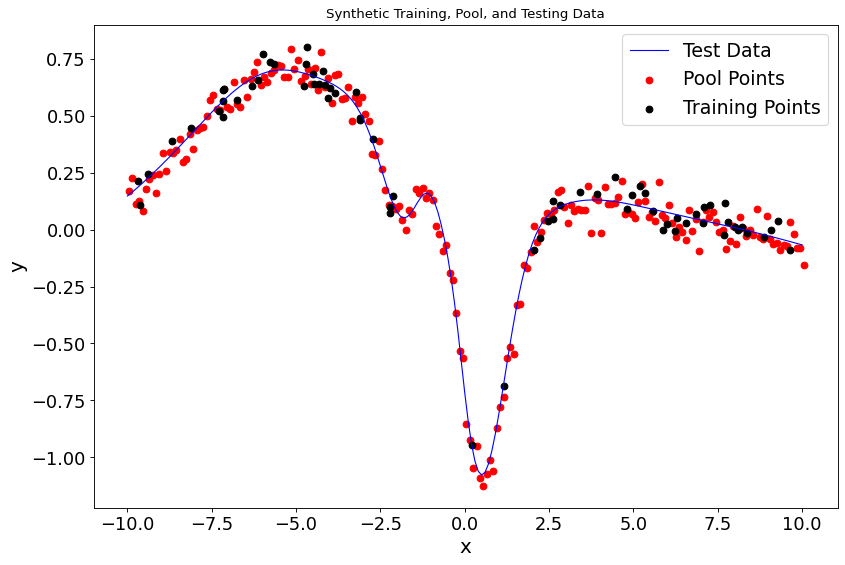

In [0]:
#Plotting training, pool, and testing data

plt.figure(figsize=(12, 8), dpi=80)
plt.plot(test_x, test_y, color='b', linewidth=1.0, label="Test Data")
plt.scatter(pool_x, pool_y, color='r', linewidth=1.0, label="Pool Points")
plt.scatter(chosen_sample_x, chosen_sample_y, color='black', linewidth=1.0, label="Training Points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc = 1)
plt.title("Synthetic Training, Pool, and Testing Data")    

In [0]:


def predict_with_uncertainty(f, x, n_iter=100):
    """Function generating non-deterministic predictions using MC dropout and returning the mean and variance of these predictions
    Adapted from: https://stackoverflow.com/questions/43529931/how-to-calculate-prediction-uncertainty-using-keras
      f: function mapping model input and Keras backend learning_phase flag to model output
      x: input
      n_iter: number of repreated MC dropout predictions per point
    """
    result = np.zeros((n_iter,x.shape[0]))
    for i in range(n_iter):
        predictions = np.array(f((x, 1))[0])[:,0]
        result[i,:] = predictions
    prediction = result.mean(axis=0)
    uncertainty = result.var(axis=0)
    return prediction, uncertainty

#Training Model
dropout_prob = 0.2
#lengthscale = 2
Weight_Decay = 0.0005
num_neurons = 256
model = Sequential([
    Dense(num_neurons, activation='relu', W_regularizer=l2(Weight_Decay), input_shape=(1,)),
    Dropout(dropout_prob),
    Dense(num_neurons, activation='relu', W_regularizer=l2(Weight_Decay)),
    Dropout(dropout_prob),
    Dense(num_neurons, activation='relu', W_regularizer=l2(Weight_Decay)),
    Dropout(dropout_prob),
    Dense(1, W_regularizer=l2(Weight_Decay))
])
#Training a new model/loading a model already trained on the synthetic data

model.compile(loss='mean_squared_error', optimizer='adam')
#model.save("/content/gdrive/My Drive/Active_Learning_Expected_Improvement_Maximization/1DEIVisualization/1D_Models/orig_model_" + str(model_num))
model.fit(chosen_sample_x, chosen_sample_y, epochs=300, verbose=0)
#model = load_model("/content/gdrive/My Drive/Active_Learning_Expected_Improvement_Maximization/1DEIVisualization/1D_Models/orig_model_1")
f = K.function([model.layers[0].input, K.learning_phase()],
        [model.layers[-1].output])
#Generating test predictions with uncertainty
test_predictions_with_uncertainty = predict_with_uncertainty(f, np.expand_dims(test_x, axis=1))
y_test_predicted = test_predictions_with_uncertainty[0]
test_uncertainty_pred = test_predictions_with_uncertainty[1]
test_mse = np.mean(np.square(y_test_predicted - test_y))
print('test mse: ' + str(test_mse))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", input_shape=(1,), kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg...)`


test mse: 0.030336908680154668


In [0]:
#Proportion of average dropout variance that is defined to be inverse model precision (tau inverse)
tau_inv_proportion = 0.15

def multi_mask_predict(layer_fn, multi_mask_input):
    """Applies Keras model layers to multiple arrays of layer inputs for all points across J fixed dropout masks
    #Arguments
        layer_fn: keras backend function applying the mapping corresponding to keras model layers
        multi_mask_input: numpy array of layer inputs for all points across J fixed dropout masks
    #Returns
        predictions from layer_fn applied to multi_mask_input as a numpy array
    """
    layer_output = []
    for mask_num in range(multi_mask_input.shape[0]):
        layer_output.append(layer_fn((multi_mask_input[mask_num], 1)))
        #layer_output.append(layer_fn([multi_mask_input[mask_num]]))
    return np.array(layer_output)


def create_dropout_masks(dim, num_masks, drop_prob):
    """Creates dropout masks that are fixed across all model inputs for use in estimation of Var(Y_{sample})
    Note: this function is specific to the keras models used in this 1D experiment
    #Arguments
      dim: the numpy array shape of values entering the generated dropout masks for all points across all J fixed dropout masks
      num_masks: J, the number of dropout masks used in estimation of Var(Y_{sample})
      drop_prob: the dropout probability
    #Returns
      dropout masks used in estimation of Var(Y_{sample})
    """
    if len(dim)==3:
        return 1/(1-drop_prob)*np.random.choice(2, size=((num_masks, 1, dim[2])), p=[drop_prob, 1-drop_prob])
    else:
        assert(len(dim)==4)
        return 1/(1-drop_prob)*np.random.choice(2, size=((dim[0], 1, 1, dim[3])), p=[drop_prob, 1-drop_prob])

def apply_dropout_masks(a,b):
    return np.squeeze(np.multiply(a,b))

def ei_acquisition_fn_model_var (univ_covariance, num_pool_samples, num_training_samples, batch_size):
    """Applies batch-mode EI active learning to query points
    #Arguments
        univ_covariance: Var(Y_{sample})
        num_pool_samples: number of pool points in D_{sample}
        num_training_samples: number of training points in D_{sample}
        batch_size: number of queried points per batch
    #Returns
        the indices of queried pool points as they are arranged in univ_covariance
    """
    acq_ind = []
    for acq_num in range(batch_size):
        all_acq_values = np.zeros(num_pool_samples)
        for new_pt_ind in range(num_pool_samples):
            covariance_vector = univ_covariance[num_training_samples+new_pt_ind,:]
            all_acq_values[new_pt_ind] = np.sum(np.square(covariance_vector))/(univ_covariance[num_training_samples+new_pt_ind, num_training_samples+new_pt_ind])
        sorted_top_ind = np.flip(np.argsort(all_acq_values))
        found_new_ind = False
        top_ind_ctr = -1
        while (found_new_ind == False):
            top_ind_ctr += 1
            new_top_ind = sorted_top_ind[top_ind_ctr]
            if new_top_ind not in acq_ind:
                acq_ind.append(new_top_ind)
                found_new_ind = True
        top_cov_vector = np.expand_dims(univ_covariance[num_training_samples+acq_ind[-1], :], axis=1)
        univ_covariance = univ_covariance - np.matmul(top_cov_vector, top_cov_vector.T)/univ_covariance[num_training_samples+acq_ind[-1], num_training_samples+acq_ind[-1]]
    return acq_ind  

def fixed_mask_forward_pass(model, forward_pass_input, num_masks, dropout_prob):
    """Makes model predictions with J dropout masks that are fixed across points to enable estimation of Var(Y_{sample})
    Function is specific to the given model.
    #Arguments
        model: keras model
        forward_pass_input: X_{sample}
        num_masks: J, the number of dropout masks being used in estimation of Var(Y_{sample}) and calculation of the EI acquisition function
        dropout_prob: dropout probability 
    #Returns
        MC dropout predictions across sample points enabling estimation of Var(Y_{sample}), i.e. \hat{Y}_{sample}
    """
    dense_1 = K.function([model.layers[0].input, K.learning_phase()],
                    [model.layers[0].output])
    dense_2 = K.function([model.layers[2].input, K.learning_phase()],
                    [model.layers[2].output])
    dense_3 = K.function([model.layers[4].input, K.learning_phase()],
                    [model.layers[4].output])
    dense_4 = K.function([model.layers[6].input, K.learning_phase()],
                    [model.layers[6].output])
    dense_1_output = np.array(dense_1((np.expand_dims(forward_pass_input, axis=1), 1)))
    dense_1_masks = create_dropout_masks(dense_1_output.shape, num_masks, dropout_prob)
    dense_2_input = apply_dropout_masks(dense_1_output, dense_1_masks)
    dense_2_output = multi_mask_predict(dense_2, dense_2_input)
    dense_2_masks = create_dropout_masks(dense_2_output.shape, num_masks, dropout_prob)
    dense_3_input = apply_dropout_masks(dense_2_output, dense_2_masks)
    dense_3_output = multi_mask_predict(dense_3, dense_3_input)
    dense_3_masks = create_dropout_masks(dense_3_output.shape, num_masks, dropout_prob)
    dense_4_input = apply_dropout_masks(dense_3_output, dense_3_masks)
    predictions =  np.squeeze(multi_mask_predict(dense_4, dense_4_input))
    return predictions
    """
    print(dense_1_output.shape)
    print(dense_1_masks.shape)
    print(dense_2_input.shape)
    print(dense_2_output.shape)
    print(dense_2_masks.shape)
    print(dense_3_input.shape)
    print(predictions.shape)
    """


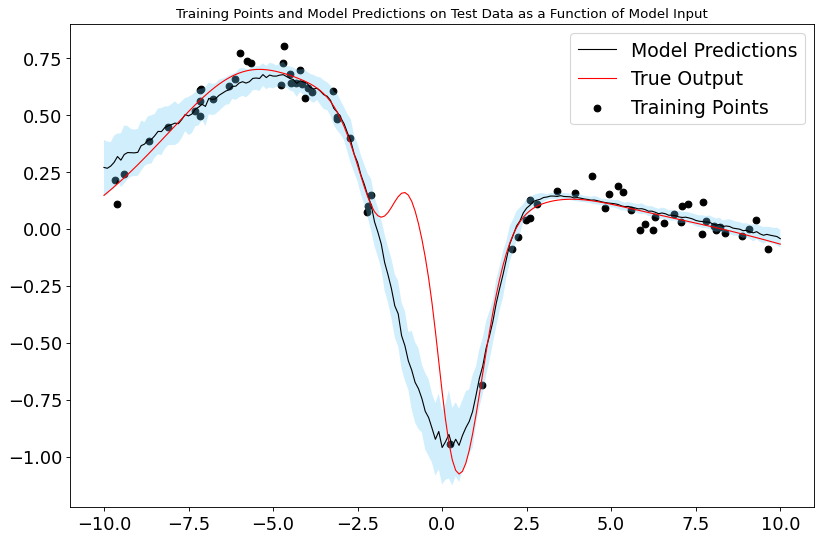

In [0]:

#Plotting model predictions with MC dropout uncertainty
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(test_x, y_test_predicted, color='black', linewidth=1.0, label="Model Predictions")
plt.scatter(chosen_sample_x, chosen_sample_y, color='black', linewidth=1.0, label="Training Points")
plt.plot(test_x, test_y, color='red', linewidth=1.0, label="True Output")
plt.fill_between(
  test_x,
  y_test_predicted - np.sqrt(test_uncertainty_pred),
  y_test_predicted + np.sqrt(test_uncertainty_pred),
  alpha=0.3,
  facecolor='#65c9f7',
  interpolate=True)
plt.title("Training Points and Model Predictions on Test Data as a Function of Model Input")
plt.legend(loc = 1)
plt.show()

Text(0.5, 1.0, 'Heatmap of Covariance Between Points')

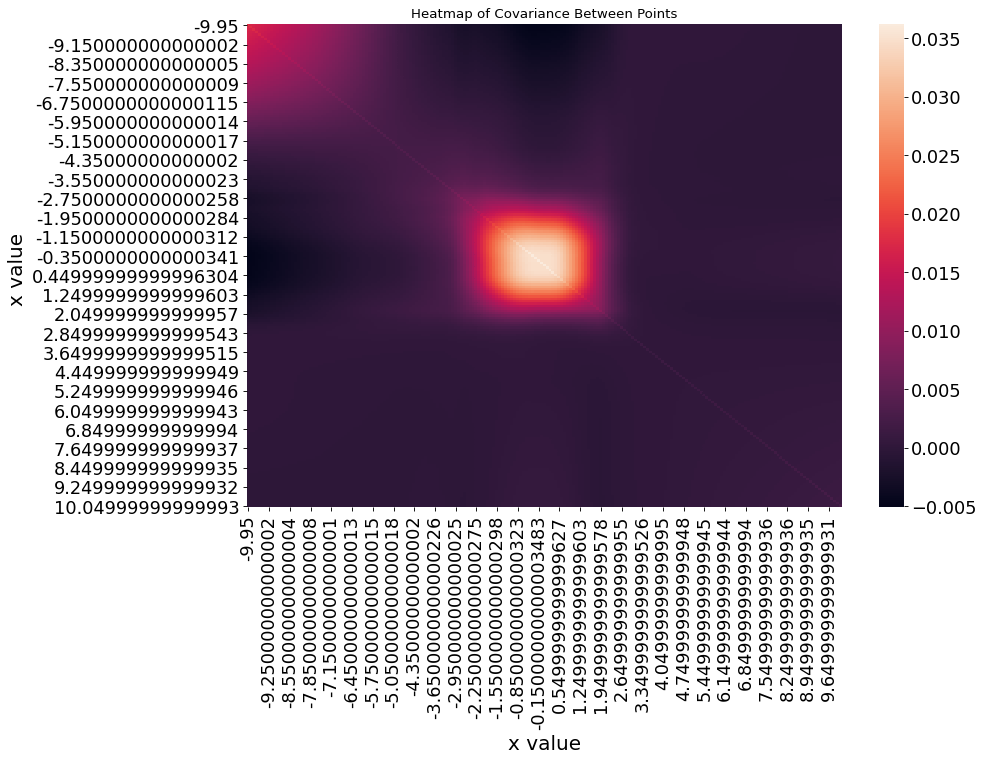

In [0]:
#Evaluating and illustrating a heatmap of Var(Y_{sample})
cov_itr = 50

my_predictions = fixed_mask_forward_pass(model, pool_x, 50, dropout_prob)
y_predicted_pool = np.mean(my_predictions, axis=0)
avg_var = np.mean(np.var(my_predictions, axis=0))
tau_inv = avg_var * tau_inv_proportion

#Var(Y_{sample}) = Var(\hat{Y}_{sample}) + tau^{-1} I 
cov_grid = np.cov(my_predictions.T) + tau_inv * np.identity(my_predictions.shape[1])

#Creating heatmap of Var(Y_{sample})
x_1 = [j for j in pool_x for i in range(len(pool_x))]
x_2 = np.array([pool_x for k in range(len(pool_x))]).flatten()
df_covgrid = pd.DataFrame(data={'x value':x_1, 'x value ':x_2, 'Covariance':cov_grid.flatten()})
df_covgrid = df_covgrid.pivot(index='x value ', columns='x value', values='Covariance')
plt.figure(figsize=(12, 8), dpi=80)
ax_1 = sns.heatmap(df_covgrid)
plt.title("Heatmap of Covariance Between Points")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars


Queried inputs: [-0.85 -9.75 -2.75  1.85  0.35]


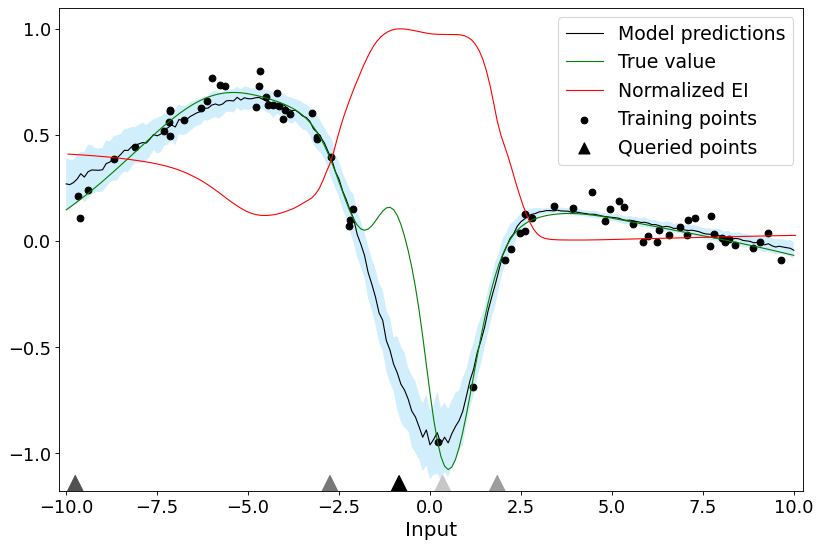

In [0]:
#Calculating EI acquisition function values
all_ei_values = np.zeros(len(pool_x))
orig_trace = np.trace(cov_grid)
for new_pt_ind in range(len(pool_x)):
    covariance_vector = np.expand_dims(cov_grid[new_pt_ind, :], 1)
    updated_univ_covariance = np.subtract(cov_grid, np.matmul(covariance_vector, covariance_vector.T)/(cov_grid[new_pt_ind, new_pt_ind]))
    all_ei_values[new_pt_ind] = orig_trace - np.trace(updated_univ_covariance)
#Running batch mode EI acquisition (batch size 5)
batch_size = 5
batch_acq_ind = ei_acquisition_fn_model_var (cov_grid, len(pool_y), 0, batch_size)
print("Queried inputs: " + str(pool_x[batch_acq_ind]))

#Matplotlib font size settings for figure readibility (taken from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
LEGEND_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize

#Plotting EI acquisition results on synthetic data
min_plot_y = np.amin(np.concatenate((y_test_predicted, chosen_sample_y, test_y)))-0.1
plt.figure(figsize=(12, 8), dpi=80)
plt.axis([np.amin(test_x)-0.2, np.amax(pool_x)+0.2, min_plot_y, 1.1])
plt.plot(test_x, y_test_predicted, color='black', linewidth=1.0, label="Model predictions")
plt.fill_between(
  test_x,
  y_test_predicted - np.sqrt(test_uncertainty_pred),
  y_test_predicted + np.sqrt(test_uncertainty_pred),
  alpha=0.3,
  facecolor='#65c9f7',
  interpolate=True)
plt.scatter(chosen_sample_x, chosen_sample_y, color='black', linewidth=1.0, label="Training points")
plt.scatter(pool_x[batch_acq_ind], [min_plot_y for i in range(batch_size)], color=cm.get_cmap('Greys')(np.array([1.0, 0.75, 0.61, 0.48, 0.33])), label="Queried points", marker="^", s=750)
plt.plot(test_x, test_y, color='green', linewidth=1.0, label="True value")
plt.plot(pool_x, all_ei_values/np.amax(all_ei_values), color='red', linewidth=1.0, label="Normalized EI")
lgnd = plt.legend(loc = 1)
lgnd.legendHandles[4]._sizes = [100]
plt.xlabel("Input")
plt.show()

#np.save("/content/gdrive/My Drive/Active_Learning_Expected_Improvement_Maximization/1DEIVisualization/1D_Models/NormalizedEI.npy" , all_ei_values/np.amax(all_ei_values))
#np.save("/content/gdrive/My Drive/Active_Learning_Expected_Improvement_Maximization/1DEIVisualization/1D_Models/QueriedInputs.npy", pool_x[batch_acq_ind])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", input_shape=(1,), kernel_regularizer=<keras.reg...)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_regularizer=<keras.reg...)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_regularizer=<keras.reg...)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg...)`
  del sys.path[0]


New Test MSE: 0.0043392098090284555


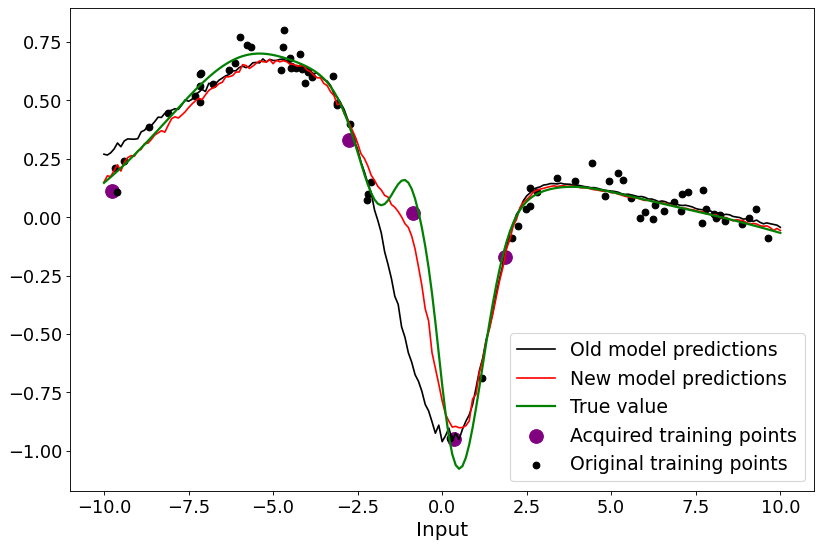

Old test MSE/New test MSE: 6.991344050023493


In [0]:
#Plotting model performance on augmented training set

#Updating weight decay so that it scales proportionally to 1/N, where N is the number of training points
new_wd = 0.93333 * Weight_Decay

model = Sequential([
    Dense(num_neurons, activation='relu', W_regularizer=l2(new_wd), input_shape=(1,)),
    Dropout(dropout_prob),
    Dense(num_neurons, activation='relu', W_regularizer=l2(new_wd)),
    Dropout(dropout_prob),
    Dense(num_neurons, activation='relu', W_regularizer=l2(new_wd)),
    Dropout(dropout_prob),
    Dense(1, W_regularizer=l2(new_wd))
])
model.compile(loss='mean_squared_error', optimizer='adam')

sample_x_augmented = np.concatenate((chosen_sample_x, pool_x[batch_acq_ind]))
sample_y_augmented = np.concatenate((chosen_sample_y, pool_y[batch_acq_ind]))
model.fit(sample_x_augmented, sample_y_augmented, epochs=300, verbose=0)
#model.save("/content/gdrive/My Drive/Active_Learning_Expected_Improvement_Maximization/1DEIVisualization/1D_Models/new_model_" + str(model_num))
#model = load_model("/content/gdrive/My Drive/Active_Learning_Expected_Improvement_Maximization/1DEIVisualization/1D_Models/new_model_1")
f = K.function([model.layers[0].input, K.learning_phase()],
        [model.layers[-1].output])


test_predictions_with_uncertainty_new = predict_with_uncertainty(f, np.expand_dims(test_x, axis=1))
y_test_predicted_new = test_predictions_with_uncertainty_new[0]
test_uncertainty_pred_new = test_predictions_with_uncertainty_new[1]

test_mse_new = np.mean(np.square(y_test_predicted_new - test_y))
print('New Test MSE: ' + str(test_mse_new))

#Plotting new model predictions
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(test_x, y_test_predicted, color='black', linewidth=1.5, label="Old model predictions")
plt.plot(test_x, y_test_predicted_new, color='red', linewidth=1.5, label="New model predictions")
plt.scatter(pool_x[batch_acq_ind], pool_y[batch_acq_ind], color='purple', linewidth=1.0, s=150,label="Acquired training points")
plt.scatter(chosen_sample_x, chosen_sample_y, color='black', linewidth=1.0, label="Original training points")
plt.plot(test_x, test_y, color='green', linewidth=2.0, label="True value")
plt.legend(loc = 4)
plt.xlabel("Input")
plt.show()

print('Old test MSE/New test MSE: ' + str(test_mse/test_mse_new))


In [0]:
#np.save(data_path+"chosen_sample_x.npy",chosen_sample_x)
#np.save(data_path+"chosen_sample_y.npy",chosen_sample_y)